In [1]:
from nltk.util import everygrams, ngrams
from nltk.lm import Vocabulary, NgramCounter, MLE, WittenBellInterpolated, KneserNeyInterpolated, Laplace, Lidstone
from nltk.lm.models import InterpolatedLanguageModel
from nltk.lm.smoothing import KneserNey 
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
import markovModels as mm
from collections import Counter 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from extractFeatures import *
import music21 as m21

#/!\ Only if restarting the kernel :
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

m21.environment.set('musescoreDirectPNGPath', '/home/homer/Programmes/MuseScore-3.5.0-x86_64.AppImage')

In [2]:
data = np.load("data/ChoralesMelodies.npy")

## Simple Markov Models

In [3]:
def _logScore(model, testSequence) :
    n=model.order
    thisLogScore = []
    for i in tqdm(range(n-1,len(testSequence))) :
        thisLogScore.append(model.logscore(testSequence[i], testSequence[i-n+1:i]))
    return np.array(thisLogScore)

def _score(model, testSequence) :
    n=model.order
    thisScore = []
    for i in tqdm(range(n-1, len(testSequence))) :
        thisScore.append(model.score(testSequence[i], testSequence[i-n+1:i]))
    return np.array(thisScore)

def _shannonEntropy(model, testSequence, normalized = True) :
    """Compute Shannon Entropy
    Normalized by testSequence if normalized = True"""
    
    thisLogScore = _logScore(model, testSequence)
    thisScore = _score(model, testSequence)
    if normalized :
        return -np.mean(thisLogScore*thisScore)
    else :
        return -np.sum(thisLogScore*thisScore)
    
def _perplexity(model, testSequence) :
    thisLogScore = _logScore(model, testSequence)
    return (2**np.sum(thisLogScore))**(-1/len(testSequence))

In [5]:
shannonEntropyLDem1 = []
for n in range (1, 20) :
    trainSet = data[:400][:1]
    testSet = list(flatten(data[400:]))[:40]
    train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
    model = MLE(n)
    model.fit(train_data, padded_sents)
    shannonEntropyLDem1.append(_perplexity(model, testSet))

100%|██████████| 40/40 [00:00<00:00, 60985.88it/s]
<ipython-input-3-900992cd5d8d>:28: RuntimeWarning: divide by zero encountered in double_scalars
  return (2**np.sum(thisLogScore))**(-1/len(testSequence))
100%|██████████| 22/22 [00:00<00:00, 19865.38it/s]


In [6]:
n=3
shannonEntropyKN = []
for n in range (1, 20) :
    trainSet = data[:400][:1]
    testSet = list(flatten(data[400:]))[:40]
    train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
    model = KneserNeyInterpolated(n)
    model.fit(train_data, padded_sents)
    shannonEntropyKN.append(_perplexity(model, testSet))

100%|██████████| 22/22 [00:00<00:00, 7065.98it/s]


# Test 

In [10]:
def myPerplexity(model, testNgrams) : 
    perp = []
    for test in enumerate(testNgrams) :
        perp.append(model.perplexity(test[1]))
    return np.mean(np.array(perp))

In [12]:
myPerpLD01 = []
for n in tqdm(range(1, 2)) :
    trainSet = data[:400]
    testSet = data[400:401]
    train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
    test_data, _ = padded_everygram_pipeline(n, testSet)
    model = Lidstone(0.1,n)
    model.fit(train_data, padded_sents)
    a = myPerplexity(model, test_data)
    myPerpLD01.append(a)

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


In [171]:
myPerpLD2 = []
for n in tqdm(range(1, 10)) :
    trainSet = data[:400]
    testSet = data[400:420]
    train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
    test_data, _ = padded_everygram_pipeline(n, testSet)
    model = Lidstone(2,n)
    model.fit(train_data, padded_sents)
    a = myPerplexity(model, test_data)
    myPerpLD2.append(a)

100%|██████████| 9/9 [04:18<00:00, 28.73s/it]


In [161]:
myPerpLP = []
for n in tqdm(range(1, 10)) :
    trainSet = data[:400]
    testSet = data[400:420]
    train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
    test_data, _ = padded_everygram_pipeline(n, testSet)
    model = Laplace(n)
    model.fit(train_data, padded_sents)
    a = myPerplexity(model, test_data)
    myPerpLP.append(a)

100%|██████████| 9/9 [04:04<00:00, 27.18s/it]


In [162]:
myPerpKN = []
for n in tqdm(range(1, 10)) :
    trainSet = data[:400]
    testSet = data[400:420]
    train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
    test_data, _ = padded_everygram_pipeline(n, testSet)
    model = KneserNeyInterpolated(n)
    model.fit(train_data, padded_sents)
    a = myPerplexity(model, test_data)
    myPerpKN.append(a)

100%|██████████| 9/9 [04:11<00:00, 27.94s/it]


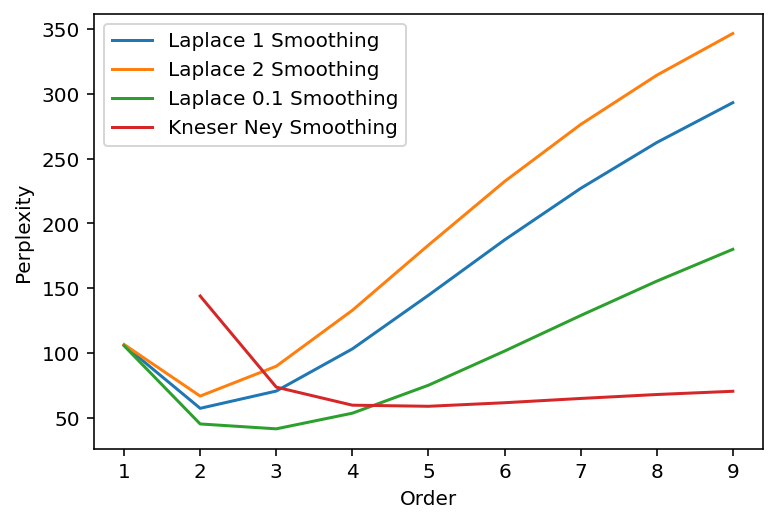

In [174]:
plt.plot([i for i in  range(1,10)],myPerpLP, label = "Laplace 1 Smoothing")
plt.plot([i for i in  range(1,10)],myPerpLD2, label = "Laplace 2 Smoothing")
plt.plot([i for i in  range(1,10)],myPerpLD01, label = "Laplace 0.1 Smoothing")
plt.plot([i for i in  range(2,10)],myPerpKN[1:], label = "Kneser Ney Smoothing")
plt.ylabel("Perplexity")
plt.xlabel("Order")
plt.legend()
plt.show()

## Create Stream 

In [206]:
n=5
trainSet = data[:400]
train_data, padded_sents = padded_everygram_pipeline(n, trainSet)
model = Lidstone(0.1, n)
model.fit(train_data, padded_sents)
melody = model.generate(100)
stream = melody2stream(melody)
stream.show()
name = "LD01_"+str(n)+".mid"
stream.write("midi", "Compositions/MarkovModels/"+name)